## NuMI Analysis: Nue Smearing

#### Get the smearing matix for nue

First, setup.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
from collections import defaultdict

main_path = ls.main_path
sys.path.append(main_path)

/home/alex/NuMI/PELEE/


In [2]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [3]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

Now get some data.

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

# Name of root files for the various samples
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""
BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""


#actually fetch datasets
mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [mc,nue,ext,data,dirt] 

variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']

# These are examples of variables present in MC samples only
varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
variables = list(set(variables))
print(variables)


# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


# Load the variables into your dataframes    
dirt = dirt.pandas.df(variables+varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
mc   = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas.df(variables, flatten=False)

['sub', 'nproton', 'shr_tkfit_nhits_V', 'shr_theta', 'shr_score', 'topological_score', 'shr_tkfit_nhits_Y', 'shr_distance', 'reco_nu_vtx_sce_x', 'n_showers', 'reco_nu_vtx_sce_z', 'shrsubclusters0', 'shr_py', 'shr_energy_tot_cali', 'run', 'contained_fraction', 'tksh_distance', 'shr_energy', 'shr_tkfit_dedx_Y', 'shr_tkfit_dedx_U', 'hits_ratio', 'ccnc', 'shr_energy_cali', 'nu_pdg', 'trkshrhitdist2', 'tksh_angle', 'CosmicIPAll3D', 'shr_tkfit_nhits_U', 'flash_time', 'shr_px', 'shrsubclusters1', 'trk_energy', 'selected', 'reco_nu_vtx_sce_y', 'shrsubclusters2', 'npion', 'nslice', 'n_tracks', 'slnhits', 'shr_tkfit_npoints', 'category', 'n_showers_contained', 'n_tracks_contained', 'trk_energy_tot', 'trk_score_v', 'evt', 'shr_phi', 'shr_tkfit_dedx_V', 'slnunhits', 'shr_pz', 'shrmoliereavg']


The following cell allows us to reload original data event weights. No weights have been added to data or ext so these are not included.

In [5]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    
#BDT

In [6]:
# Let's calculate the weights that we need to apply to the individual MC events 
# to become our best model of the NuMI data. 
# This cell calculates the GENIE Tune * PPFX correction to the MC weights and 
# cleans up extremely high (or low) weight scores (may be due to computational errors).
# The clean up is not the best practice (one should dig and understand why the weight are big/negative): 
# it's a cheat until we figure out the next best thing. Life is not perfect and your analysis won't be either. Please enojy LArbys

constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [mc,nue,dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

#BDT

Get Log Likelihood Ratio Particle ID for track candidates. Will need proton for nue, muon for numu.

In [7]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [8]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [9]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [10]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [mc,nue,ext,data,dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

#BDT

time to run:  444.4524972438812


In [11]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    #
    # secondshower_U/V/Y_dot need to be set to 9999. to match data ntuples produced with v08_00_00_43 or later;
    # the patch below is valid only to match data ntuples produced with v08_00_00_42.
    #
    #df.loc[df['secondshower_U_dot'].isna(),'secondshower_U_dot'] = 0.0 #for 0p please uncomment
    #df.loc[df['secondshower_V_dot'].isna(),'secondshower_V_dot'] = 0.0 #for 0p please uncomment
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 
    
#BDT

In [12]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
#    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
#    df['shr_tkfit_nhi'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
#    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
#    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
#    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
#    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    
    #BDT

In [13]:
#commented big tutorial had flash timer just before this

#Define neutrino reconstructed energy here
#Also make a correction to electron shower energies

INTERCEPT = 0.0
SLOPE = 0.83

df_v = [mc,nue,ext,data,dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])


#BDT

In [14]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    
#BDT    

In [15]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        
#BDT        

In [16]:
#Define signal catagories

data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11

nue["is_not_signal"] = nue["category"] != 11

#BDT

In [17]:
# Some quick clean up since some strange events get in there
mc   = mc.query('nu_e > 0.')
nue  = nue.query('nu_e > 0.')
dirt = dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [mc,nue,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    


## Selection Section

In [18]:
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

## Plotting Part

In [19]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0
####Is this needed of new BDT?
#if (USEBDT == True):
#    SPLIT = 2.

#Define the samples to feed the plotter, as well as POT normalisation for each sample
#Need MC to be compariable to the data

#fullnue = nue
#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
# 254.8 & true_nu_vtx_x > -1.55 )")
#This is abs as it defines the dataset. shouldn' need here?
#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
#nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 #254.8 & true_nu_vtx_x > -1.55)")


samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "dirt": dirt,
    "ext": ext
}

scaling = 1
# This is the data POT we normalize to (comes from the data Ntuples)
pot =  2e+20 #partial file: 8.885e+19
# This is the full MC POT scaling factor
mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
# This is the POT scaling factor for the nue CC only sample
nueratio  = pot/2.37838e+22 #2.59311e+22 #norm for intrinsic = 2.59311e+22
# This is the POT scaling factor for dirt sample
dirtratio = pot/1.42143e+21
# The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
# We scale down the EXT to account for neutrino occupancy
scalingEXT = 0.98
 # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
scalingDRT = 0.35


#Now we can define the sample normalization factors
weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}

print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

#BDT

904362
{'mc': 0.08559738414394057, 'nue': 0.008409085175623745, 'ext': 0.5612087579382191, 'dirt': 0.049246181662128984}


## BDT

In [20]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [21]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [22]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [mc, nue, dirt, ext, data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(914729, 125)
(127551, 126)
(483722, 107)
(904362, 70)
(610496, 70)


In [23]:
datasets_bdt = mc

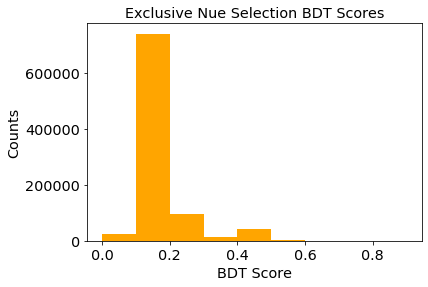

In [24]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [25]:
###Need to use the same BDT split value Katerina did
#It was BDT score > 0.575

SEL_QUERY = BDT_LOOSE_CUTS
SEL_QUERY += ' and BDT_score > 0.575'

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  0.4789296166403314  c  3
order w sum  0.4849670167220518  c  4
order w sum  0.6081289599520437  c  5
order w sum  0.8618336019701214  c  21
order w sum  1.9404238859110692  c  2
order w sum  2.124404610494145  c  31
order w sum  4.023855822156849  c  1
order w sum  3.7460561473004157  c  12
order w sum  57.03751092595994  c  11
total  71.86731934504519

SUMS
[0.47892961664033135, 0.9638966333623833, 1.5720255933144274, 2.4338591952845485, 4.374283081195617, 6.498687691689762, 10.522543513846614, 14.268599661147025, 71.3061105871071]
[0.4849670167220

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


data
dirt
ext
Universes 500
mc
nue
data
dirt
ext
Universes 500
mc
nue
data
dirt
ext
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [21 26  7  4  2  0  0  1  0  0]


/home/alex/NuMI/PELEE/plotter.py:458: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/alex/NuMI/PELEE/plotter.py:266: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


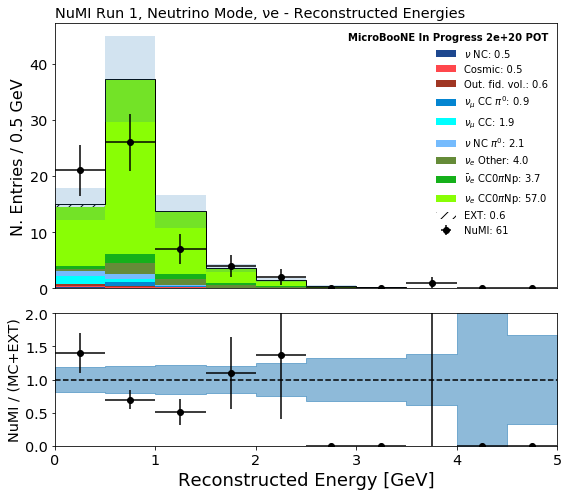

In [26]:
#Now check on a variable
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

import matplotlib.pyplot as plt
import matplotlib

#can this be done with nue_e too? For efficiencies?
VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = True, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Neutrino Mode, νe - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

In [56]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['nu_e']*weights, bins, color='deepskyblue')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True νe Energy [GeV]', fontsize=15)

    # compute efficiency
    #sel2=selected['nu_e']
    sel = ax1.hist(selected['nu_e'], bins, color='white')
    print(sel)
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylim(0, 3500)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True νe Energy and Efficiency")
    plt.text(0, 0.95, r'MicroBooNE In Progress', fontweight='bold')

    plt.show()

In [32]:
def plot_signal_and_eff_alex(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin
    nue_truth = [37.963620193059626, 153.70502409396536, 105.12433817746344, 40.84836282943223, 16.43726297406471, 7.924784559451439, 4.7246726061682125, 2.3833022701571167, 1.2904587747437404, 0.483849884068718]
    count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
    weights = [0.1*nue_truth[0], 0.6*nue_truth[1], 1.1*nue_truth[2], 1.6*nue_truth[3], 2.1*nue_truth[4], 2.6*nue_truth[5], 3.1*nue_truth[6], 3.6*nue_truth[7], 4.1*nue_truth[8], 4.6*nue_truth[9]]   
    
    gen = plt.hist(count, bins, color='deepskyblue', weights=nue_truth)
    #gen = plt.hist(df.query(signal)['nu_e'], bins, color='deepskyblue')
    plt.close()
    print(gen)
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    #sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True νe Energy [GeV]', fontsize=15)

    # compute efficiency
    #Use nu_e post selection numbers so in true bins of e
    nue_truth_reco = [3.3129663588582634, 27.547284031308195, 17.47340720212118, 5.265912008052567, 2.058917149432233, 0.6800988524854858, 0.3426644506052554, 0.20079651391073838, 0.08512010511708468, 0.028548522227268336]
    count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]

    weights = [0.1*nue_truth_reco[0], 0.6*nue_truth_reco[1], 1.1*nue_truth_reco[2], 1.6*nue_truth_reco[3], 2.1*nue_truth_reco[4], 2.6*nue_truth_reco[5], 3.1*nue_truth_reco[6], 3.6*nue_truth_reco[7], 4.1*nue_truth_reco[8], 4.6*nue_truth_reco[9]]

    sel = ax1.hist(count, bins, color='white', weights=nue_truth_reco)
    print(sel)
    #sel = ax1.hist(selected['nu_e'], bins, color='white')
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    #sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    sel = ax1.hist(count, bins, color='deepskyblue', weights=nue_truth_reco)
    ax1.set_ylim(0, 35)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True νe Energy and Efficiency")
    plt.text(0, 0.95, r'MicroBooNE In Progress', fontweight='bold')

    plt.show()

(array([ 37.964, 153.705, 105.124,  40.848,  16.437,   7.925,   4.725,
         2.383,   1.29 ,   0.484]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]), <a list of 10 Patch objects>)
(array([ 3.313, 27.547, 17.473,  5.266,  2.059,  0.68 ,  0.343,  0.201,
        0.085,  0.029]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]), <a list of 10 Patch objects>)
In bin 0 , eff =  0.08726687133657311  with error =  0.04580499078590566
In bin 1 , eff =  0.1792217540948275  with error =  0.030936006388988628
In bin 2 , eff =  0.16621657272765716  with error =  0.03630882155224814
In bin 3 , eff =  0.12891366124123707  with error =  0.05243155586968591
In bin 4 , eff =  0.12525912329083405  with error =  0.08164500932546111
In bin 5 , eff =  0.08581922289286346  with error =  0.09949805679944515
In bin 6 , eff =  0.07252660219417022  with error =  0.11932008028428484
In bin 7 , eff =  0.08425138364740495  with error =  0.17992316960398524
In bin 8 , eff =  0.0659

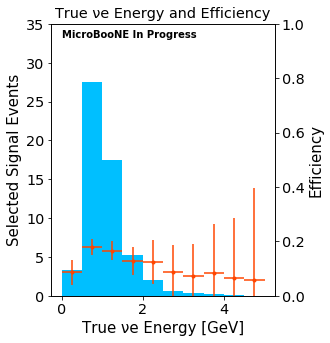

In [33]:
#SEL_QUERY = "BDT_score > 0.575"
#selected = nue.query(SEL_QUERY)


fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 12 and ccnc == 0) and nproton > 0"


#bins = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.05, 2.25, 2.45, 2.65, 2.85, 3.05]
bins = np.arange(0, 5.5, 0.5)
#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

selected = nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

#had truth as mc - should be nue?
plot_signal_and_eff_alex(selected_fid, nue, fiduc_q, bins, mc.query(fiduc_q))

### Smearing Matrix work

In [97]:
# plot the smearing matrix 
def plot_smearing(selected, signal, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1): 
                norm_array[i][j] =  norm_array[i][j] / tot_reco_events
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        print(zero_copy_smear_norm)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        #np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
        #   zero_copy_smear_norm,
        #   delimiter =", ", 
        #   fmt ='% s')

    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()

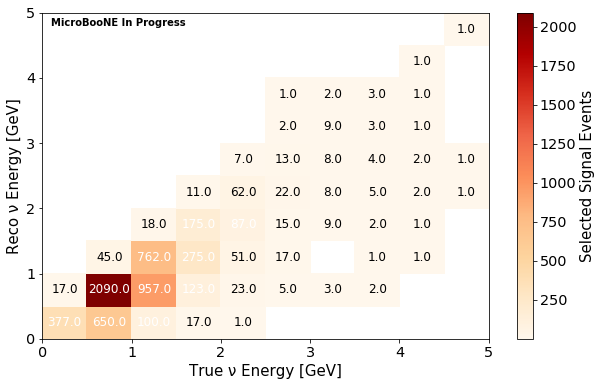

In [98]:
# true nu energy 
true_var = 'nu_e'

# reconstructed nu energy 
reco_var = 'reco_e'

bins = np.arange(0, 5.5, 0.5)

#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 12 and ccnc == 0) and nproton > 0"

fiduc_q  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 11"


selected = nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins)

[[0.957 0.233 0.054 0.028 0.004 0.    0.    0.    0.    0.   ]
 [0.043 0.75  0.521 0.205 0.1   0.067 0.077 0.1   0.    0.   ]
 [0.    0.016 0.415 0.458 0.221 0.227 0.    0.05  0.111 0.   ]
 [0.    0.    0.01  0.291 0.377 0.2   0.231 0.1   0.111 0.   ]
 [0.    0.    0.    0.018 0.268 0.293 0.205 0.25  0.222 0.333]
 [0.    0.    0.    0.    0.03  0.173 0.205 0.2   0.222 0.333]
 [0.    0.    0.    0.    0.    0.027 0.231 0.15  0.111 0.   ]
 [0.    0.    0.    0.    0.    0.013 0.051 0.15  0.111 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.111 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.333]]


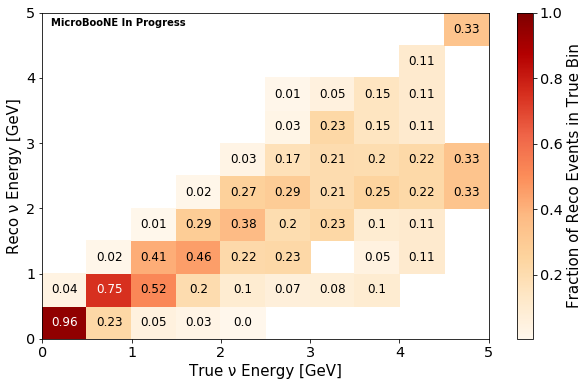

In [99]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins, norm=True)

In [126]:
with open('batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix.csv') as file:
    content = file.readlines()
effs = content[0:]
    
for i in range(10):
    effs[i]=effs[i].rstrip().rstrip(',')
    effs[i] = float(effs[i])
    
print(effs)
print("")
#----------------------------------------------------------------------------------

with open('nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv') as file:
    content = file.readlines()
smear = content[0:]

for i in range(10):
    smear[i]=smear[i].rstrip().rstrip(',')
    smear[i] = [float(idx) for idx in smear[i].split(', ')]
    
print((smear))
print("")

#------------------------------------------------------------------

#print(np.dot(effs, data_signal))
for i in range(10):
    smear[i] = [a*b for a,b in zip(smear[i], effs)]
    
print(smear)
print("")

np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
   smear,
   delimiter =", ", 
   fmt ='% s')

#--------------------------------------------------------

#Now test by multiplying with the prior_true_signal

with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal.csv') as file:
    content = file.readlines()
prior_true = content[0:]
    
for i in range(10):
    prior_true[i]=prior_true[i].rstrip().rstrip(',')
    prior_true[i] = float(prior_true[i])
    
print(prior_true)
print("")

made_data_sig = np.dot(smear, prior_true)
print(made_data_sig)
print("")

for i in made_data_sig:
    print(i)

[0.34732557021624605, 0.20496289709941323, 0.10034889412168412, 0.06197694757999727, 0.06304670091254373, 0.03941488708522243, 0.02835869187983018, 0.03216097442647323, 0.015941008628400314, 0.040242617031980066]

[[0.9568527918781726, 0.2333931777378815, 0.05443658138268917, 0.028286189683860232, 0.004329004329004329, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04314720812182741, 0.7504488330341114, 0.5209580838323353, 0.20465890183028287, 0.09956709956709957, 0.06666666666666667, 0.07692307692307693, 0.1, 0.0, 0.0], [0.0, 0.01615798922800718, 0.4148067501360915, 0.45757071547420963, 0.22077922077922077, 0.22666666666666666, 0.0, 0.05, 0.1111111111111111, 0.0], [0.0, 0.0, 0.00979858464888405, 0.2911813643926789, 0.37662337662337664, 0.2, 0.23076923076923078, 0.1, 0.1111111111111111, 0.0], [0.0, 0.0, 0.0, 0.018302828618968387, 0.2683982683982684, 0.29333333333333333, 0.20512820512820512, 0.25, 0.2222222222222222, 0.3333333333333333], [0.0, 0.0, 0.0, 0.0, 0.030303030303030304, 0.17333333333333334, 0.2

In [ ]:
##------------------------------------------------------------------

In [38]:
with open('nue_full_500_catsel_nopions_recoE_usingSelection_data_signal.csv') as file:
    content = file.readlines()
data_signal = content[0:]
    
for i in range(10):
    data_signal[i]=data_signal[i].rstrip().rstrip(',')
    data_signal[i] = float(data_signal[i])
    
print(data_signal)
print("")
#------------------------------------------------------------------------------
with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal.csv') as file:
    content = file.readlines()
prior_truth_signal = content[0:]
    
for i in range(10):
    prior_truth_signal[i]=prior_truth_signal[i].rstrip().rstrip(',')
    prior_truth_signal[i] = float(prior_truth_signal[i])
    
print(prior_truth_signal)

[16.252776516049828, 19.70314039893206, 4.414916853226545, 3.0357098650207432, 1.6034129964049364, -0.08264259569634058, -0.07212432175690564, 0.9609066753581361, 0.0, -0.008804630377731826]

[30.084810827502174, 151.62865504965998, 111.03931566210608, 43.90048763860746, 16.85484444822777, 8.271492731185546, 4.829256825653858, 2.5025045208168826, 1.2736534180956065, 0.5006552407172141]


(array([[ 5., nan, nan],
       [nan, nan, nan],
       [ 1., nan, nan]]), array([  0,  50, 100, 150]), array([  0,  50, 100, 150]), <matplotlib.collections.QuadMesh object at 0x7f148b2f3970>)


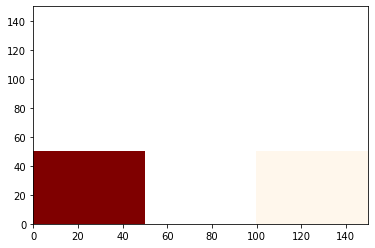

In [44]:
bins = np.arange(0, 200, 50)

smear = plt.hist2d(prior_truth_signal,data_signal,
                   bins, cmin=0.000000001, cmap='OrRd')

print(smear)

In [45]:
##--------------------------------------------------

5998
40087


ValueError: x and y must have the same length.

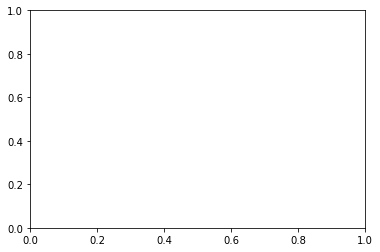

In [76]:
#prior_truth_signal

nue_nue_vars_tot_df_truth = pd.read_csv("nue_nue_varstot_full_catsel_nopions_trueE.csv")
nue_nue_weights_tot_df_truth = pd.read_csv("nue_nue_weightstot_full_catsel_nopions_trueE.csv")

nue_nue_vars_tot_truth = defaultdict(list)
nue_nue_weights_tot_truth = defaultdict(list)


nue_nue_vars_tot_truth = nue_nue_vars_tot_df_truth.to_dict()
nue_nue_weights_tot_truth = nue_nue_weights_tot_df_truth.to_dict()
nue_nue_vars_tot_truth.pop("Unnamed: 0")
nue_nue_weights_tot_truth.pop("Unnamed: 0")

poplist = []

for c in nue_nue_vars_tot_truth.keys():
    if len(nue_nue_weights_tot_truth[c][0]) > 2:
        nue_nue_weights_tot_truth[c][0] = nue_nue_weights_tot_truth[c][0][1:]
        nue_nue_weights_tot_truth[c][0] = nue_nue_weights_tot_truth[c][0][:-1]
        nue_nue_weights_tot_truth[c][0] = list(map(float,nue_nue_weights_tot_truth[c][0].split(",")))
    else:
        poplist.append(c)
        
for c in nue_nue_vars_tot_truth.keys():
    if len(nue_nue_vars_tot_truth[c][0]) > 2:
        nue_nue_vars_tot_truth[c][0] = nue_nue_vars_tot_truth[c][0][1:]
        nue_nue_vars_tot_truth[c][0] = nue_nue_vars_tot_truth[c][0][:-1]
        nue_nue_vars_tot_truth[c][0] = list(map(float,nue_nue_vars_tot_truth[c][0].split(",")))
        
for i in poplist:
    nue_nue_vars_tot_truth.pop(i)
    nue_nue_weights_tot_truth.pop(i)
    
#------------------------------------------------------------------------

#data_signal

nue_nue_vars_tot_df = pd.read_csv("nue_nue_varstot_full_catsel_nopions_recoE_usingSelection.csv")
nue_nue_weights_tot_df = pd.read_csv("nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection.csv")

nue_nue_vars_tot = defaultdict(list)
nue_nue_weights_tot = defaultdict(list)


nue_nue_vars_tot = nue_nue_vars_tot_df.to_dict()
nue_nue_weights_tot = nue_nue_weights_tot_df.to_dict()
nue_nue_vars_tot.pop("Unnamed: 0")
nue_nue_weights_tot.pop("Unnamed: 0")

poplist = []

for c in nue_nue_vars_tot.keys():
    if len(nue_nue_weights_tot[c][0]) > 2:
        nue_nue_weights_tot[c][0] = nue_nue_weights_tot[c][0][1:]
        nue_nue_weights_tot[c][0] = nue_nue_weights_tot[c][0][:-1]
        nue_nue_weights_tot[c][0] = list(map(float,nue_nue_weights_tot[c][0].split(",")))
    else:
        poplist.append(c)
        
for c in nue_nue_vars_tot.keys():
    if len(nue_nue_vars_tot[c][0]) > 2:
        nue_nue_vars_tot[c][0] = nue_nue_vars_tot[c][0][1:]
        nue_nue_vars_tot[c][0] = nue_nue_vars_tot[c][0][:-1]
        nue_nue_vars_tot[c][0] = list(map(float,nue_nue_vars_tot[c][0].split(",")))
        
for i in poplist:
    nue_nue_vars_tot.pop(i)
    nue_nue_weights_tot.pop(i)
    
###############################################################

nue_mc_vars_tot_df = pd.read_csv("nue_mc_varstot_full_catsel_nopions_recoE_usingSelection.csv")
nue_mc_weights_tot_df = pd.read_csv("nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection.csv")

nue_mc_vars_tot = defaultdict(list)
nue_mc_weights_tot = defaultdict(list)


nue_mc_vars_tot = nue_mc_vars_tot_df.to_dict()
nue_mc_weights_tot = nue_mc_weights_tot_df.to_dict()
nue_mc_vars_tot.pop("Unnamed: 0")
nue_mc_weights_tot.pop("Unnamed: 0")

poplist = []

for c in nue_mc_vars_tot.keys():
    if len(nue_mc_weights_tot[c][0]) > 2:
        nue_mc_weights_tot[c][0] = nue_mc_weights_tot[c][0][1:]
        nue_mc_weights_tot[c][0] = nue_mc_weights_tot[c][0][:-1]
        nue_mc_weights_tot[c][0] = list(map(float,nue_mc_weights_tot[c][0].split(",")))
    else:
        poplist.append(c)
        
for c in nue_mc_vars_tot.keys():
    if len(nue_mc_vars_tot[c][0]) > 2:
        nue_mc_vars_tot[c][0] = nue_mc_vars_tot[c][0][1:]
        nue_mc_vars_tot[c][0] = nue_mc_vars_tot[c][0][:-1]
        nue_mc_vars_tot[c][0] = list(map(float,nue_mc_vars_tot[c][0].split(",")))
        
for i in poplist:
    nue_mc_vars_tot.pop(i)
    nue_mc_weights_tot.pop(i)
    
###############################################################

nue_dirt_vars_tot_df = pd.read_csv("nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection.csv")
nue_dirt_weights_tot_df = pd.read_csv("nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection.csv")

nue_dirt_vars_tot = defaultdict(list)
nue_dirt_weights_tot = defaultdict(list)


nue_dirt_vars_tot = nue_dirt_vars_tot_df.to_dict()
nue_dirt_weights_tot = nue_dirt_weights_tot_df.to_dict()
nue_dirt_vars_tot.pop("Unnamed: 0")
nue_dirt_weights_tot.pop("Unnamed: 0")

#print(nue_dirt_vars_tot[c][0])

poplist = []

for c in nue_dirt_vars_tot.keys():
    if len(nue_dirt_weights_tot[c][0]) > 2:
        nue_dirt_weights_tot[c][0] = nue_dirt_weights_tot[c][0][1:]
        nue_dirt_weights_tot[c][0] = nue_dirt_weights_tot[c][0][:-1]
        nue_dirt_weights_tot[c][0] = list(map(float,nue_dirt_weights_tot[c][0].split(",")))
    else:
        poplist.append(c)
        
for c in nue_dirt_vars_tot.keys():
    if len(nue_dirt_vars_tot[c][0]) > 2:
        nue_dirt_vars_tot[c][0] = nue_dirt_vars_tot[c][0][1:]
        nue_dirt_vars_tot[c][0] = nue_dirt_vars_tot[c][0][:-1]
        nue_dirt_vars_tot[c][0] = list(map(float,nue_dirt_vars_tot[c][0].split(",")))
        
for i in poplist:
    nue_dirt_vars_tot.pop(i)
    nue_dirt_weights_tot.pop(i)

########################################
pup = list(nue_nue_vars_tot.values())

i = 0
for c in nue_nue_vars_tot.keys():
    nue_nue_vars_tot[str(c)] = pup[i][0]
    i = i + 1
    
pup2 = list(nue_nue_weights_tot.values())

i = 0
for c in nue_nue_weights_tot.keys():
    nue_nue_weights_tot[str(c)] = pup2[i][0]
    i = i + 1
############################################# 
pup = list(nue_mc_vars_tot.values())

i = 0
for c in nue_mc_vars_tot.keys():
    nue_mc_vars_tot[str(c)] = pup[i][0]
    i = i + 1
    
pup2 = list(nue_mc_weights_tot.values())

i = 0
for c in nue_mc_weights_tot.keys():
    nue_mc_weights_tot[str(c)] = pup2[i][0]
    i = i + 1
############################################# 
pup = list(nue_dirt_vars_tot.values())

i = 0
for c in nue_dirt_vars_tot.keys():
    nue_dirt_vars_tot[str(c)] = pup[i][0]
    i = i + 1
    
pup2 = list(nue_dirt_weights_tot.values())

i = 0
for c in nue_dirt_weights_tot.keys():
    nue_dirt_weights_tot[str(c)] = pup2[i][0]
    i = i + 1
############################################# 

def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss = [nue_nue_vars_tot, nue_mc_vars_tot, nue_dirt_vars_tot]
weightss = [nue_nue_weights_tot, nue_mc_weights_tot, nue_dirt_weights_tot]
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

print(len(varss_tot[0]['11']))
#print((weightss_tot[0]['11']))

print(len(nue_nue_vars_tot_truth['11'][0]))

###########################################################################

bins = np.arange(0, 5.5, 0.5)

smear = plt.hist2d(nue_nue_vars_tot_truth['11'][0],varss_tot[0]['11'],
                   bins, cmin=0.000000001, cmap='OrRd', weights = (nue_nue_weights_tot_truth['11'][0],weightss_tot[0]['11']))
